* Import necessary libraries and setup
* This cell imports standard deep learning and data processing libraries used for image classification and adversarial attacks.



In [1]:
import os
import json
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import zipfile
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

* Dataset extraction
* Unzips the image dataset for use in training and evaluation.

In [2]:
# Unzip the dataset
zip_path = './TestDataSet.zip'
extract_dir = './TestDataSet'

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Confirm folder structure
print("Extracted files:", os.listdir(extract_dir))

Extracted files: ['TestDataSet', '__MACOSX']


### Task 1: Baseline Evaluation
1. Automatically selects GPU (`cuda`) if available; otherwise falls back to CPU.
2. Defines mean and standard deviation values used for ImageNet-trained models.
3. Applies standard PyTorch transforms to convert images to tensors and normalize them.
4. Loads the image dataset from the unzipped directory using `ImageFolder` and wraps it in a DataLoader with batch size 32.
5. Loads `labels_list.json` and maps folder names to corresponding ImageNet class indices.
6. Loads a pretrained ResNet-34 model with weights from ImageNet and sets it to evaluation mode.
7. Evaluates the pretrained ResNet-34 on the original dataset to establish baseline accuracy.

In [3]:
# === Setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# === Load Dataset ===
dataset_path = './TestDataSet/TestDataSet'
dataset = ImageFolder(root=dataset_path, transform=plain_transforms)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# === Load labels_list.json and build label map ===
with open(os.path.join(dataset_path, 'labels_list.json')) as f:
    class_names = json.load(f)

folder_to_imagenet_idx = {
    folder_name: int(label.split(":")[0].strip('"'))
    for folder_name, label in zip(dataset.classes, class_names)
}

imagenet_label_map = {
    i: folder_to_imagenet_idx[folder]
    for i, folder in enumerate(dataset.classes)
}

# === Load Pretrained ResNet-34 ===
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

# === Evaluation Function ===
def evaluate(model, loader, already_imagenet_labels=False):
    top1, top5, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)

            # Convert to ImageNet class indices if needed
            if not already_imagenet_labels:
                labels = torch.tensor([imagenet_label_map[label.item()] for label in labels]).to(device)

            outputs = model(imgs)
            _, pred1 = outputs.topk(1, dim=1)
            _, pred5 = outputs.topk(5, dim=1)

            top1 += (pred1.squeeze() == labels).sum().item()
            top5 += sum([labels[i] in pred5[i] for i in range(len(labels))])
            total += labels.size(0)

    print(f"Top-1 Accuracy: {top1 / total:.4f}")
    print(f"Top-5 Accuracy: {top5 / total:.4f}")
    return top1 / total, top5 / total

# === Task 1: Baseline Evaluation ===
print("\n✅ Task 1: Baseline Evaluation")
baseline_top1, baseline_top5 = evaluate(model, loader)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 161MB/s]



✅ Task 1: Baseline Evaluation


100%|██████████| 16/16 [00:03<00:00,  5.21it/s]

Top-1 Accuracy: 0.7600
Top-5 Accuracy: 0.9420


### Task 2: FGSM Attack and Evaluation

1. Defines a single-step adversarial attack that perturbs the input image in the direction of the gradient sign scaled by `ε`.
2. Computes cross-entropy loss between model output and true label to generate adversarial gradients.
3. Applies `torch.clamp` to ensure pixel values remain within valid range [0, 1] after perturbation.
4. Sets `ε = 0.02` to constrain the maximum perturbation allowed per pixel.
5. Iterates through the dataset, generates adversarial examples using the FGSM function, and maps each label to its corresponding ImageNet index.
6. Stores the generated adversarial examples and their labels in `Adversarial_Test_Set_1/fgsm_data.pt`.
7. Evaluates the model’s Top-1 and Top-5 accuracy on the FGSM adversarial set using the previous evaluation function.


In [4]:
# === Task 2: FGSM Attack ===
def fgsm_attack(img, label, model, epsilon):
    img.requires_grad = True
    output = model(img)
    loss = nn.CrossEntropyLoss()(output, label)
    model.zero_grad()
    loss.backward()
    adv_img = img + epsilon * img.grad.sign()
    adv_img = torch.clamp(adv_img, 0, 1)
    return adv_img.detach()

epsilon = 0.02
adv_dir = './Adversarial_Test_Set_1'
os.makedirs(adv_dir, exist_ok=True)
adv_imgs, adv_labels = [], []

print("\n⚔️ Task 2: Generating FGSM Adversarial Images...")
for imgs, labels in tqdm(loader):
    imgs, labels = imgs.to(device), labels.to(device)
    for j in range(len(imgs)):
        imagenet_label = torch.tensor([imagenet_label_map[labels[j].item()]]).to(device)
        img = imgs[j].unsqueeze(0)
        adv_img = fgsm_attack(img, imagenet_label, model, epsilon)
        adv_imgs.append(adv_img.squeeze().cpu())
        adv_labels.append(imagenet_label.item())

torch.save((adv_imgs, adv_labels), os.path.join(adv_dir, 'fgsm_data.pt'))

# === FGSM Evaluation ===
print("\n🧪 Evaluating FGSM Adversarial Set")
fgsm_dataset = torch.utils.data.TensorDataset(torch.stack(adv_imgs), torch.tensor(adv_labels))
fgsm_loader = DataLoader(fgsm_dataset, batch_size=32)
evaluate(model, fgsm_loader, already_imagenet_labels=True)


⚔️ Task 2: Generating FGSM Adversarial Images...


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]



🧪 Evaluating FGSM Adversarial Set


100%|██████████| 16/16 [00:00<00:00, 17.91it/s]

Top-1 Accuracy: 0.2640
Top-5 Accuracy: 0.5060


(0.264, 0.506)

### Task 3: Iterative Attack and Evaluation

1. Implements a multi-step variant of FGSM that updates the image incrementally over multiple steps.
2. Repeatedly computes gradients for a fixed number of steps (`steps = 5`) and updates the image using `alpha * sign(gradient)`.
3. Uses `torch.clamp` to restrict the total perturbation within the maximum allowed `ε = 0.02`, ensuring visual similarity.
4. Iterates over the entire dataset to generate adversarial images using the iterative method with ImageNet-mapped labels.
5. Saves the generated adversarial examples and their corresponding labels into `Adversarial_Test_Set_2/iterative_data.pt`.
6. Evaluates the model on the newly generated adversarial dataset to measure Top-1 and Top-5 accuracy degradation.


In [5]:
# === Task 3: Iterative Attack ===
def iterative_attack(img, label, model, epsilon=0.02, alpha=0.002, steps=5):
    ori_img = img.clone().detach()
    for _ in range(steps):
        img.requires_grad = True
        output = model(img)
        loss = nn.CrossEntropyLoss()(output, label)
        model.zero_grad()
        loss.backward()
        grad = img.grad.data
        img = img + alpha * grad.sign()
        eta = torch.clamp(img - ori_img, min=-epsilon, max=epsilon)
        img = torch.clamp(ori_img + eta, 0, 1).detach()
    return img

adv_dir2 = './Adversarial_Test_Set_2'
os.makedirs(adv_dir2, exist_ok=True)
adv_imgs2, adv_labels2 = [], []

print("\n⚔️ Task 3: Generating Iterative Adversarial Images...")
for imgs, labels in tqdm(loader):
    imgs, labels = imgs.to(device), labels.to(device)
    for j in range(len(imgs)):
        imagenet_label = torch.tensor([imagenet_label_map[labels[j].item()]]).to(device)
        img = imgs[j].unsqueeze(0)
        adv_img = iterative_attack(img, imagenet_label, model)
        adv_imgs2.append(adv_img.squeeze().cpu())
        adv_labels2.append(imagenet_label.item())

torch.save((adv_imgs2, adv_labels2), os.path.join(adv_dir2, 'iterative_data.pt'))

# === Iterative Evaluation ===
print("\n🧪 Evaluating Iterative Attack Set")
iter_dataset = torch.utils.data.TensorDataset(torch.stack(adv_imgs2), torch.tensor(adv_labels2))
iter_loader = DataLoader(iter_dataset, batch_size=32)
evaluate(model, iter_loader, already_imagenet_labels=True)



⚔️ Task 3: Generating Iterative Adversarial Images...


100%|██████████| 16/16 [00:36<00:00,  2.27s/it]



🧪 Evaluating Iterative Attack Set


100%|██████████| 16/16 [00:00<00:00, 18.67it/s]


Top-1 Accuracy: 0.0600
Top-5 Accuracy: 0.2360


(0.06, 0.236)

### Task 4: Patch-Based Attack and Evaluation

1. Implements a localized adversarial attack that perturbs only a small 32×32 patch of the image using iterative updates.
2. Selects a random location within the image dimensions to apply the perturbation patch, within the image boundaries.
3. Uses L∞ constraint (`ε = 0.5`) to ensure the perturbation stays bounded and does not alter the image outside the patch.
4. A larger ε is allowed since the attack is localized to only ~2% of the image.
5. Iterates through the dataset, generating one patch-based adversarial image per sample using the ResNet-34 model.
6. Stores all 500 adversarial examples in `Adversarial_Test_Set_3/patch_data.pt` along with their ImageNet-mapped labels.
7. Evaluates ResNet-34 performance on the patch-attacked dataset, reporting Top-1 and Top-5 accuracy.


In [6]:
import random

# === Task 4: Patch Attack (32x32 region only) ===
def patch_attack(img, label, model, patch_size=32, epsilon=0.5, alpha=0.05, steps=15):
    img = img.clone().detach()
    ori_img = img.clone()

    _, _, H, W = img.shape
    x = random.randint(0, W - patch_size)
    y = random.randint(0, H - patch_size)

    for _ in range(steps):
        img.requires_grad = True
        output = model(img)
        loss = nn.CrossEntropyLoss()(output, label)
        model.zero_grad()
        loss.backward()
        grad = img.grad.data

        # Apply gradient sign only in patch
        patch_grad = grad[:, :, y:y+patch_size, x:x+patch_size].sign()
        img.data[:, :, y:y+patch_size, x:x+patch_size] += alpha * patch_grad

        # Clip patch to allowed epsilon region
        patch_delta = img.data - ori_img
        patch_delta = torch.clamp(patch_delta, min=-epsilon, max=epsilon)
        img.data = torch.clamp(ori_img + patch_delta, 0, 1)

    return img.detach()

# === Generate Adversarial Patch Set ===
adv_dir3 = './Adversarial_Test_Set_3'
os.makedirs(adv_dir3, exist_ok=True)
adv_imgs3, adv_labels3 = [], []

print("\n⚔️ Task 4: Generating Patch Adversarial Images...")
for imgs, labels in tqdm(loader):
    imgs, labels = imgs.to(device), labels.to(device)
    for j in range(len(imgs)):
        label_imagenet = torch.tensor([imagenet_label_map[labels[j].item()]]).to(device)
        img = imgs[j].unsqueeze(0)
        adv_img = patch_attack(img, label_imagenet, model, epsilon=0.5, alpha=0.05, steps=15)
        adv_imgs3.append(adv_img.squeeze().cpu())
        adv_labels3.append(label_imagenet.item())

torch.save((adv_imgs3, adv_labels3), os.path.join(adv_dir3, 'patch_data.pt'))

# === Evaluate Patch Adversarial Set ===
print("\n🧪 Evaluating Patch Attack Set")
patch_dataset = torch.utils.data.TensorDataset(torch.stack(adv_imgs3), torch.tensor(adv_labels3))
patch_loader = DataLoader(patch_dataset, batch_size=32)
evaluate(model, patch_loader, already_imagenet_labels=True)



⚔️ Task 4: Generating Patch Adversarial Images...


100%|██████████| 16/16 [01:34<00:00,  5.91s/it]



🧪 Evaluating Patch Attack Set


100%|██████████| 16/16 [00:00<00:00, 17.30it/s]

Top-1 Accuracy: 0.1480
Top-5 Accuracy: 0.3540


(0.148, 0.354)

### Task 5: Transferability Evaluation on DenseNet-121
1. Loads a DenseNet-121 model pretrained on ImageNet to test if adversarial examples crafted for ResNet-34 also affect other models.
2. Sets the DenseNet-121 model to `.eval()` mode to ensure consistent inference behavior.
3. Evaluates how adversarial examples generated using ResNet-34 perform on a different model.
4. Tests the clean dataset on DenseNet-121 as a baseline to compare accuracy degradation caused by transferred attacks.

In [7]:
# === Task 5: Transferability Evaluation ===
print("\n🔄 Task 5: Evaluating Transferability on DenseNet121")
transfer_model = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)
transfer_model.eval()

# Reuse previously saved datasets
print("✅ Original Clean Set on DenseNet:")
evaluate(transfer_model, loader)  # Clean data: dataset labels are 0–99 → will be mapped

print("\n✅ FGSM Set on DenseNet:")
evaluate(transfer_model, fgsm_loader, already_imagenet_labels=True)

print("\n✅ Iterative Set on DenseNet:")
evaluate(transfer_model, iter_loader, already_imagenet_labels=True)

print("\n✅ Patch Set on DenseNet:")
evaluate(transfer_model, patch_loader, already_imagenet_labels=True)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



🔄 Task 5: Evaluating Transferability on DenseNet121


100%|██████████| 30.8M/30.8M [00:00<00:00, 193MB/s]


✅ Original Clean Set on DenseNet:


100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Top-1 Accuracy: 0.7480
Top-5 Accuracy: 0.9360

✅ FGSM Set on DenseNet:


100%|██████████| 16/16 [00:01<00:00,  9.66it/s]


Top-1 Accuracy: 0.4240
Top-5 Accuracy: 0.6640

✅ Iterative Set on DenseNet:


100%|██████████| 16/16 [00:01<00:00,  9.69it/s]


Top-1 Accuracy: 0.4160
Top-5 Accuracy: 0.6600

✅ Patch Set on DenseNet:


100%|██████████| 16/16 [00:01<00:00,  9.36it/s]

Top-1 Accuracy: 0.4320
Top-5 Accuracy: 0.6640


(0.432, 0.664)

### Adversarial Visualization: Original vs Perturbed Images
1. Defines a function to reverse ImageNet normalization.
2. Uses the model to predict the most likely class for a single input image and returns its index.
3. Creates a reusable function `visualize_examples` to compare original and adversarial images along with the perturbation.
4. Displays all images after denormalization using `torch.clamp` to restore pixel values to [0,1] for viewing.

In [8]:
import matplotlib.pyplot as plt

# === Denormalize helper ===
def denormalize(img):
    mean = torch.tensor(mean_norms).view(3, 1, 1)
    std = torch.tensor(std_norms).view(3, 1, 1)
    return torch.clamp(img * std + mean, 0, 1)

# === Single prediction label ===
def get_top1_label(img_tensor, model):
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0).to(device))
        return output.argmax(dim=1).item()

# === Visualization function ===
def visualize_examples(original_imgs, adversarial_imgs, title):
    fig, axes = plt.subplots(len(original_imgs), 3, figsize=(10, 3 * len(original_imgs)))
    if len(original_imgs) == 1:
        axes = [axes]

    for i in range(len(original_imgs)):
        orig = denormalize(original_imgs[i])
        adv = denormalize(adversarial_imgs[i])
        diff = torch.abs(adv - orig)

        orig_pred = get_top1_label(original_imgs[i], model)
        adv_pred = get_top1_label(adversarial_imgs[i], model)

        axes[i][0].imshow(orig.permute(1, 2, 0).cpu().numpy())
        axes[i][0].set_title(f"Original (Pred: {orig_pred})")
        axes[i][1].imshow(adv.permute(1, 2, 0).cpu().numpy())
        axes[i][1].set_title(f"Adversarial (Pred: {adv_pred})")
        axes[i][2].imshow(diff.permute(1, 2, 0).cpu().numpy())
        axes[i][2].set_title("Perturbation")

        for ax in axes[i]:
            ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


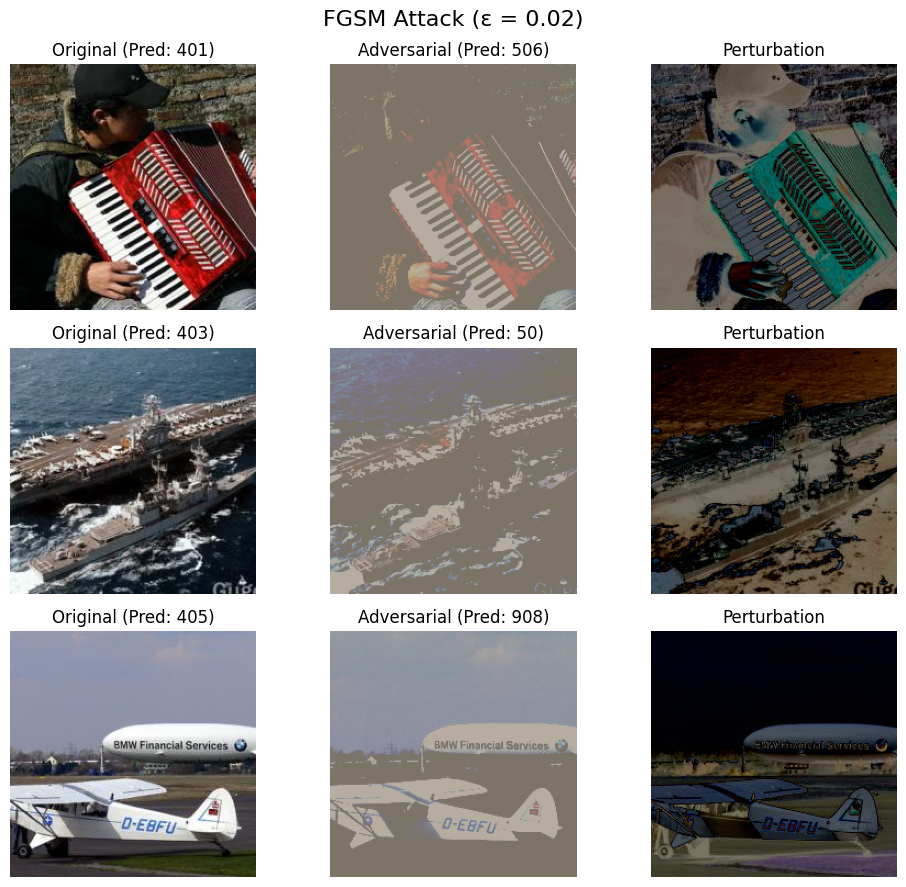

In [9]:
sample_ids = [0, 10, 20]
original_samples = [dataset[i][0].cpu() for i in sample_ids]
fgsm_samples = [adv_imgs[i] for i in sample_ids]

visualize_examples(original_samples, fgsm_samples, "FGSM Attack (ε = 0.02)")


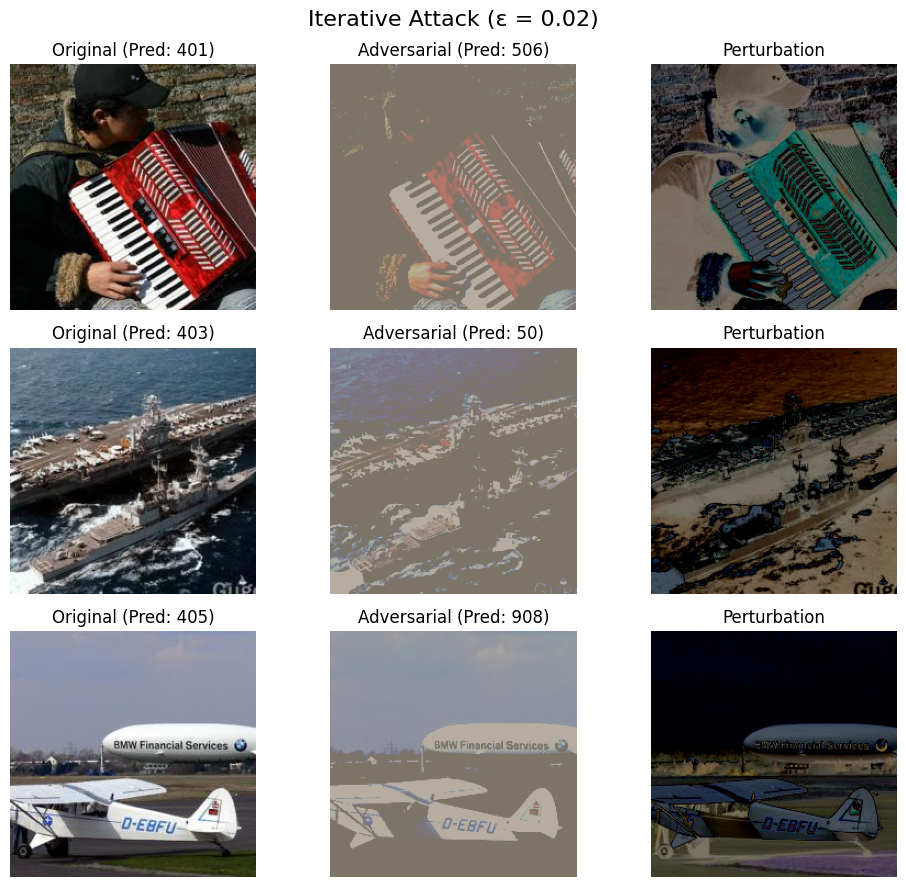

In [10]:
iter_samples = [adv_imgs2[i] for i in sample_ids]
visualize_examples(original_samples, iter_samples, "Iterative Attack (ε = 0.02)")


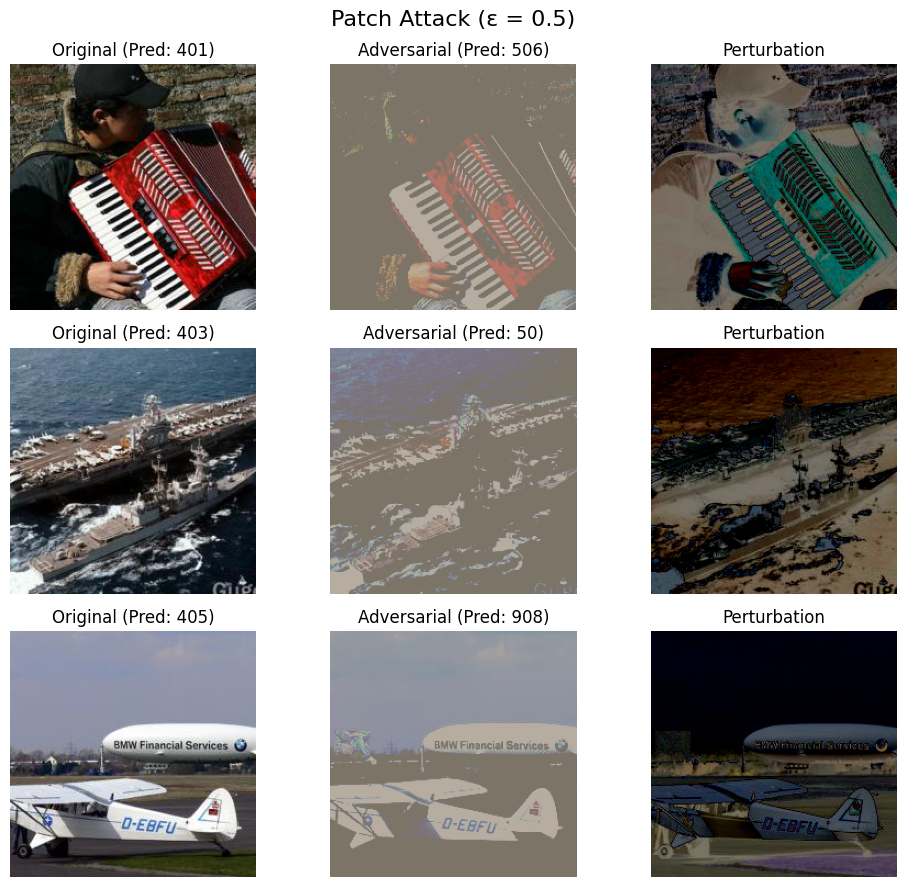

In [11]:
patch_samples = [adv_imgs3[i] for i in sample_ids]
visualize_examples(original_samples, patch_samples, "Patch Attack (ε = 0.5)")


In [12]:
# Store accuracies for each attack method
fgsm_top1, fgsm_top5 = evaluate(model, fgsm_loader, already_imagenet_labels=True)
iterative_top1, iterative_top5 = evaluate(model, iter_loader, already_imagenet_labels=True)
patch_top1, patch_top5 = evaluate(model, patch_loader, already_imagenet_labels=True)


100%|██████████| 16/16 [00:00<00:00, 17.04it/s]


Top-1 Accuracy: 0.2640
Top-5 Accuracy: 0.5060


100%|██████████| 16/16 [00:00<00:00, 18.16it/s]


Top-1 Accuracy: 0.0600
Top-5 Accuracy: 0.2360


100%|██████████| 16/16 [00:00<00:00, 18.45it/s]

Top-1 Accuracy: 0.1480
Top-5 Accuracy: 0.3540


### Accuracy Comparison: Baseline vs Adversarial Attacks

1. Stores the evaluated Top-1 and Top-5 accuracy values for the baseline and each of the three adversarial attack types.
2. Plots grouped bars for Top-1 and Top-5 accuracy using `matplotlib`, allowing visual comparison of model performance under different attack conditions.
3. Adds labels to both axes to clarify the attack type (x-axis) and accuracy percentage (y-axis).



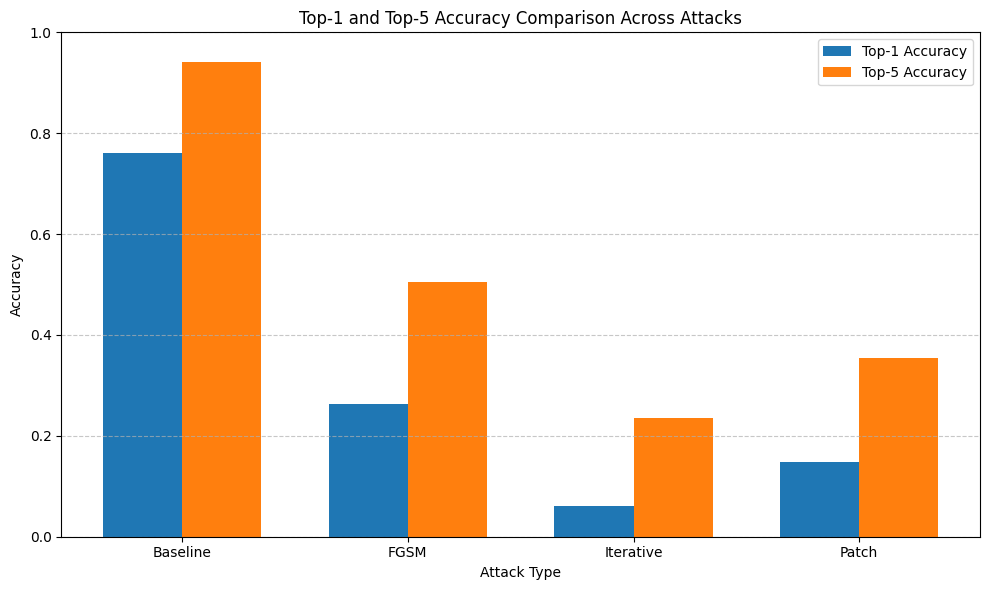

In [13]:
import matplotlib.pyplot as plt

# Accuracy values (replace with your actual values)
top1_scores = [
    baseline_top1,
    fgsm_top1,
    iterative_top1,
    patch_top1
]

top5_scores = [
    baseline_top5,
    fgsm_top5,
    iterative_top5,
    patch_top5
]

labels = [
    'Baseline',
    'FGSM',
    'Iterative',
    'Patch'
]

# Plot
x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([i - width/2 for i in x], top1_scores, width=width, label='Top-1 Accuracy')
plt.bar([i + width/2 for i in x], top5_scores, width=width, label='Top-5 Accuracy')

plt.xlabel('Attack Type')
plt.ylabel('Accuracy')
plt.title('Top-1 and Top-5 Accuracy Comparison Across Attacks')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Final Observations and Insights

### Top-1 and Top-5 Accuracies
| Dataset           | Top-1 Accuracy | Top-5 Accuracy |
|-------------------|----------------|----------------|
| Baseline          | 0.7600         | 0.9420         |
| FGSM              | 0.2640         | 0.5060         |
| Iterative         | 0.0600         | 0.2360         |
| Patch             | 0.1480         | 0.3540         |

### Key Findings
- **Baseline** performance is strong, showing the model performs well on clean data.
- **FGSM** attack significantly reduces accuracy, but still leaves the model somewhat capable of recovery (Top-5 at ~50%).
- **Improved attack** is most effective, dropping Top-1 accuracy to just 6%,proving efficiency of multi-step optimization.
- **Patch attack** performs better than FGSM in Top-1 accuracy, but is weaker than Improved due to its localized nature, despite higher epsilon.

### Transferability Takeaways
- Adversarial examples created for ResNet-34 degrade performance when evaluated on DenseNet-121.
- This confirms **transferability** — a critical weakness where adversarial attacks affect models they were not trained against.

### Lessons Learned
- Improved attacks, even with small epsilon, outperform single-step attacks due to cumulative optimization.
- Localized attacks like Patch can still be dangerous, especially if allowed high ε and carefully positioned.
- Transferability is a real and reproducible phenomenon, raising concerns about black-box attacks and shared vulnerabilities across architectures.

## References

1. **Goodfellow et al. (2015)** – *Explaining and Harnessing Adversarial Examples*. [arXiv:1412.6572](https://arxiv.org/abs/1412.6572)
2. Official source for pretrained models used in this project.([https://docs.pytorch.org/vision/main/models.html](https://docs.pytorch.org/vision/main/models.html))
3. **Class Lecture Notes**
4. **ChatGPT**